# Lab 2 (Part 2): Regularizing MLPs


------------------------------------------------------
------------------------------------------------------
*Deep Learning. Master in Big Data Analytics*

*Emilie Naples*

------------------------------------------------------


In this second part of this MLPs side project, I will be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world. See a sample below.

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML

Image(url= "https://miro.medium.com/max/3200/1*QQVbuP2SEasB0XAmvjW0AA.jpeg", width=400, height=200)

The goal is to build a neural network that can take one of these images and predict the digit in the image. Unlike the MNIST case, for this problem, the model **easily overfits**, so addressing this issue is an important problem here. To do so, I will experiment with early stopping, dropout, and L2 weight regularization.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes to them!!

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

## Part I. Download FMNIST with `torchvision`

I download the MNIST dataset, then create training and test datasets.

In [ ]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



Lets take a look to the mini-batch size and plot a sample.

In [ ]:
dataiter = iter(trainloader)   #To iterate through the dataset

images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


This is what one of the images looks like.

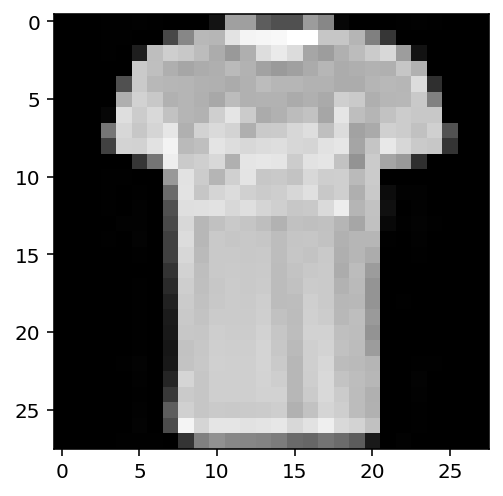

In [ ]:
plt.imshow(images[1].numpy().reshape([28,28]), cmap='Greys_r')

## Part II. Visualize overfiting

> I will train a Neural Network with four layers, hidden dimmensions 256, 128 and 64 neurons. I will use ReLU activation functions, and a log-Softmax output layer. I take the following steps:
> - Create a class defining the NN model.
> - Extend the class to incorporate a training method and call it trainloop.
> - Train the model for 30 epochs and evaluate train/test performance.

In [ ]:
class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels):
        super().__init__()
        self.L1 = nn.Linear(dimx,hidden1)
        self.L2 = nn.Linear(hidden1,hidden2)
        self.L3 = nn.Linear(hidden2,hidden3)
        self.L4 = nn.Linear(hidden3,nlabels)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
      x = self.L1(x)
      x = self.relu(x)
      x = self.L2(x)
      x = self.relu(x)
      x = self.L3(x)
      x = self.relu(x)
      x = self.L4(x)
      x = self.softmax(x)
      return x

In [ ]:
class MLP_extended(MLP):

    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs=30,lr=0.001):

        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels)  # initialize the `MLP`!

        self.lr = lr

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.epochs = epochs

        self.criterion = nn.NLLLoss()

        # List to store the loss evolution along training
        self.loss_during_training = []

    # extend the class to incorporate a training method
    def trainloop(self,trainloader):
            for e in range(int(self.epochs)):
                running_loss = 0.
                for images, labels in trainloader:
                    self.optim.zero_grad()  # RESET GRADIENTS!

                    # forward pass
                    out = self.forward(images.view(images.shape[0], -1)) # -1 reshape image in a vector, 0th column refers to batch size
                    loss = self.criterion(out,labels) # compare output with the labels
                    running_loss += loss.item() # update the loss

                    # backwardpass
                    loss.backward() # do backpropagation
                    self.optim.step() # update parameters

                self.loss_during_training.append(running_loss/len(trainloader))

                if(e % 1 == 0): # Every 10 epochs
                    print("Training loss after %d epochs: %f"
                          %(e,self.loss_during_training[-1]))

    def eval_performance(self,loader):
        loss = 0
        accuracy = 0

        # Turn off gradients
        with torch.no_grad():
            for images,labels in loader:
                logprobs = my_newest_MLP.forward(images.view(images.shape[0], -1)) # softmax for logprobabilities

                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        return accuracy/len(loader)

In [ ]:
my_newest_MLP = MLP_extended(dimx=784,hidden1=256, hidden2=128, hidden3=64, nlabels=10,epochs=10,lr=1e-3)
my_newest_MLP.trainloop(trainloader)

Training loss after 0 epochs: -0.536915
Training loss after 1 epochs: -0.563040
Training loss after 2 epochs: -0.583778
Training loss after 3 epochs: -0.617179
Training loss after 4 epochs: -0.647763
Training loss after 5 epochs: -0.649312
Training loss after 6 epochs: -0.653856
Training loss after 7 epochs: -0.653800
Training loss after 8 epochs: -0.660971
Training loss after 9 epochs: -0.657742


In [ ]:
# evaluate train and test performance
train_accuracy = my_newest_MLP.eval_performance(trainloader)
test_accuracy = my_newest_MLP.eval_performance(testloader)
print("Training performance accuracy for this model is", float(train_accuracy))
print("Testing performance accuracy for this model is", float(test_accuracy))

Training performance accuracy for this model is 0.6674273610115051
Testing performance accuracy for this model is 0.6532643437385559


Comments: Accuracy for the model is not very good. If the training accuracy is low, this could mean that underfitting (high bias) is taking place here. Some things that could fix this (maybe in order) are: Increasing the model capacity. We could add more layers, add more neurons, and play with better architectures in this way.  

This could happen at first with any model, and as I improve it, the accuracy could change. I attempt to do so.

In light of the train/test performance, certainly the model is performing significantly better in the train set than in the test set. This is a sign of overfitting. For an early detection of overfitting, we will make use of a **validation set** that we will use to visualize the evolution of the loss function during training.

I will now split the train set into one training set (45k images) and a validation set (15k images). I do a naive splitting assuming that the data is randomized. **I could have done something smarter than this like K-Fold cross validation**, but here I am going to keep it simple.



In [ ]:
import copy

validloader = copy.deepcopy(trainloader)  # copy the object

#We take the first 45k images for training
trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]

> Now I want to modify the class above so that, during training, everytime an epoch is finished, it computes the loss function over the validation set. I store the values into a list name as `valid_loss_during_training`. When performing this step, I turn off gradients by using `with torch.no_grad()`.
>
>Then, repeat the training (30 epochs) and plot the train/validation loss along epochs. Compute the final train/validation/test performance.

In [ ]:
class MLP_extended(MLP):

    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs=30,lr=0.001):

        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels)  # initialize the `MLP`!

        self.lr = lr

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.epochs = epochs

        self.criterion = nn.NLLLoss()

        # List to store the loss evolution along training and validation
        self.loss_during_training = []
        self.valid_loss_during_training = []

    def trainloop(self,trainloader,validloader):
                for e in range(int(self.epochs)):
                    running_loss = 0.
                    for images, labels in trainloader:
                        self.optim.zero_grad() # reset gradients

                        # forward pass
                        out = self.forward(images.view(images.shape[0], -1)) # -1 reshapes the image in a vector, 0th column refers to batch size
                        loss = self.criterion(out,labels) # compare output with the labels
                        running_loss += loss.item() # update the loss

                        # backwardpass
                        loss.backward() # do backpropagation
                        self.optim.step() # update parameters

                    self.loss_during_training.append(running_loss/len(trainloader))
                    with torch.no_grad():
                        valid_running_loss = 0.
                        for images, labels in validloader:

                            # forward pass
                            out = self.forward(images.view(images.shape[0], -1)) # -1 reshapes the image in a vector, 0th column refers to batch size
                            loss = self.criterion(out,labels) # compare output with the labels
                            valid_running_loss += loss.item() # update the loss
                        self.valid_loss_during_training.append(valid_running_loss/len(validloader))

                        if e in range(int(self.epochs)): #if(e % 1 == 0): # Every 10 epochs
                            print("Training loss after %d epochs: %f"
                                %(e,self.loss_during_training[-1]))

    def eval_performance(self,loader):
        loss = 0
        accuracy = 0

        # Turn off gradients for evaluation
        with torch.no_grad():
            for images,labels in loader:
                logprobs = my_newest_MLP.forward(images.view(images.shape[0], -1)) # reshape again before forward pass

                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        return accuracy/len(loader)

In [ ]:
# now, repreat training and plot train/validation loss along epochs
my_newest_MLP = MLP_extended(dimx=28*28,hidden1=256, hidden2=128, hidden3=64, nlabels=10,epochs=30,lr=1e-3)
train_accuracy = my_newest_MLP.trainloop(trainloader, validloader)

Training loss after 0 epochs: -0.655320
Training loss after 1 epochs: -0.723569
Training loss after 2 epochs: -0.727752
Training loss after 3 epochs: -0.729491
Training loss after 4 epochs: -0.729023
Training loss after 5 epochs: -0.729958
Training loss after 6 epochs: -0.734956
Training loss after 7 epochs: -0.733417
Training loss after 8 epochs: -0.753747
Training loss after 9 epochs: -0.782341
Training loss after 10 epochs: -0.792284
Training loss after 11 epochs: -0.793828
Training loss after 12 epochs: -0.796047
Training loss after 13 epochs: -0.792448
Training loss after 14 epochs: -0.799183
Training loss after 15 epochs: -0.795375
Training loss after 16 epochs: -0.799945
Training loss after 17 epochs: -0.792362
Training loss after 18 epochs: -0.797146
Training loss after 19 epochs: -0.817324
Training loss after 20 epochs: -0.826835
Training loss after 21 epochs: -0.832243
Training loss after 22 epochs: -0.834970
Training loss after 23 epochs: -0.832149
Training loss after 24 epo

Text(0, 0.5, 'Loss')

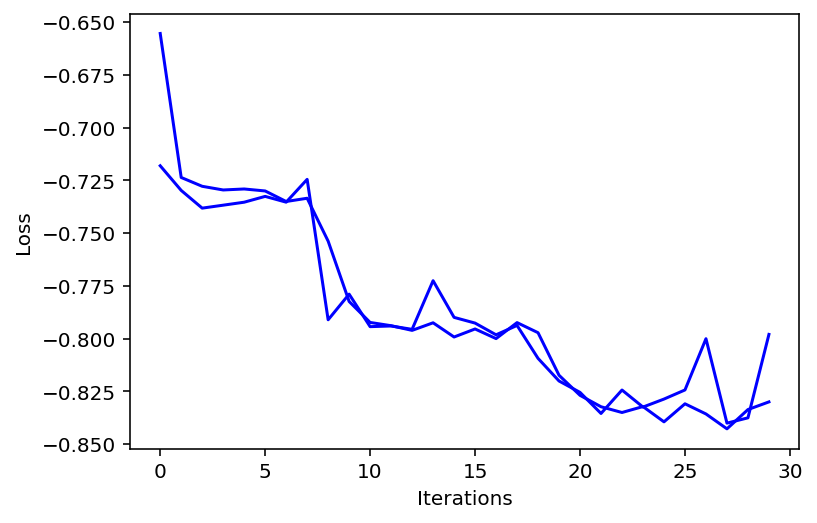

In [ ]:
# training loss
plt.plot(my_newest_MLP.loss_during_training,'-b',label='BCE Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# validation loss
plt.plot(my_newest_MLP.valid_loss_during_training,'-b',label='BCE Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [ ]:
# now we must compute train/test accuracy
train_accuracy = my_newest_MLP.eval_performance(trainloader)
valid_accuracy = my_newest_MLP.eval_performance(validloader)
test_accuracy = my_newest_MLP.eval_performance(testloader)
print("The training accuracy for the extended MLP class is ", float(train_accuracy))
print("The validation accuracy is ", float(valid_accuracy))
print("The testing accuracy is ", float(test_accuracy))


The training accuracy for the extended MLP class is  0.8030894994735718
The validation accuracy is  0.7977393865585327
The testing accuracy is  0.7890127301216125


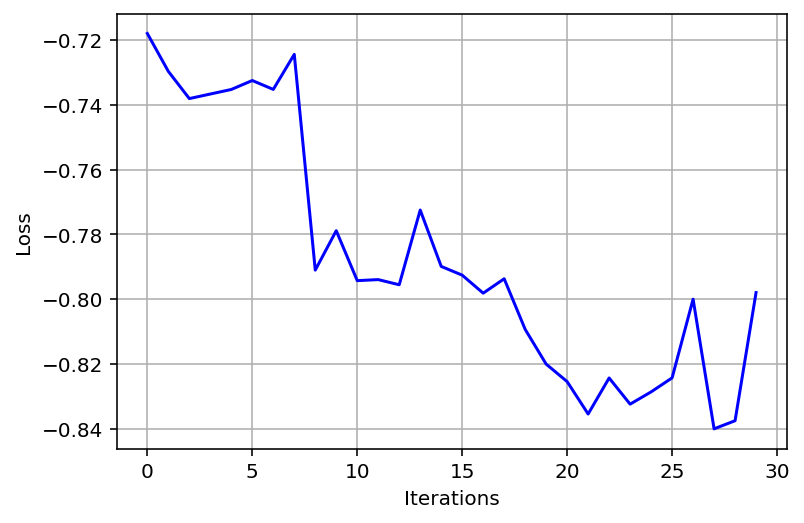

In [ ]:
# plot the loss along epochs
plt.plot(my_newest_MLP.valid_loss_during_training,'-b',label='Cross Entropy Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()

## Implement Early Stopping

If we look at the training and validation losses as we train the network, we can see it is overfitting.

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. One option we could try to fix this is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice it would be best to save the model frequently during training and then later choose the model with the lowest validation loss. **Note that with early stopping we are using the validation set to select the appropiate number of epochs.**

> Now, re-train the model again for the right number of epochs (just before the validation loss starts to grow).

In [ ]:
# avoid over-fitting with early stopping
# see this by watching increasing validation loss
# use the version of the model with lowest validation loss

# repeat training for 8 epochs, as after this, the loss increases again
my_newest_MLP = MLP_extended(dimx=784,hidden1=256, hidden2=128, hidden3=64, nlabels=10, epochs=8, lr=1e-3)
my_newest_MLP.trainloop(trainloader,validloader)

Training loss after 0 epochs: -0.702211
Training loss after 1 epochs: -0.808014
Training loss after 2 epochs: -0.823421
Training loss after 3 epochs: -0.828093
Training loss after 4 epochs: -0.831531
Training loss after 5 epochs: -0.833801
Training loss after 6 epochs: -0.838100
Training loss after 7 epochs: -0.837192


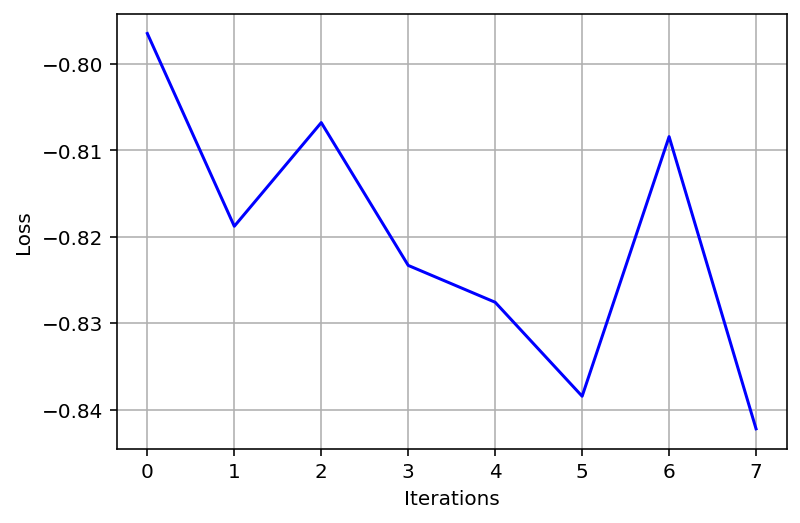

In [ ]:
# plot train/validation loss along epochs
plt.plot(my_newest_MLP.valid_loss_during_training,'-b',label='Cross Entropy Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()

In [ ]:
# evaluate train, validation, and test performance

train_accuracy = my_newest_MLP.eval_performance(trainloader)
valid_accuracy = my_newest_MLP.eval_performance(validloader)
test_accuracy = my_newest_MLP.eval_performance(testloader)
print("Training performance accuracy for this model is", float(train_accuracy))
print("Validation performance accuracy is", float(train_accuracy))
print("Testing performance accuracy is", float(test_accuracy))

Training performance accuracy for this model is 0.851318359375
Validation performance accuracy is 0.851318359375
Testing performance accuracy is 0.8324044346809387


Here, or accuracy looks a bit better than at the beginning where we were seeing percentages in the 60s.

## Part III. Using Dropout Regularization

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data.

The following code corresponds to a 2 layer NN where I use dropout in the intermediate hidden space:


```python
class MLP_dropout(nn.Module):
    def __init__(self,dimx,hidden1,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)  
        
        self.output2 = nn.Linear(hidden1,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)  
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output2(x)
        x = self.logsoftmax(x)
        return x

```

During training, I want to use dropout to prevent overfitting, but during inference I want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, I use `self.eval()`. This sets the model to evaluation mode where the dropout probability is 0. Dropout can be turned back on by setting the model to train mode with `self.train()` (**This is why I do not call our training method `train` anymore**).

> - Now I create a new NN class that modifies the previous one by incorporating a dropout step with `p=0.2`  after every ReLU non-linearity is applied.
> - For this new model, I plot the evolution of the training and validation losses and compare with the case with no dropout.
> - Repeat the experiments for a dropout probability of `p=0.1` and `p=0.3`.

In [ ]:
class MLPdrop(nn.Module):

    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels):
        super().init()
        self.L1 = nn.Linear(dimx,hidden1)
        self.L2 = nn.Linear(hidden1,hidden2)
        self.L3 = nn.Linear(hidden2,hidden3)
        self.L4 = nn.Linear(hidden3,nlabels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2) # DROPOUT PROBABILITY OF 0.2
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
      # pass input tensor again through each operation above
      x = self.L1(x)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.L2(x)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.L3(x)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.L4(x)
      x = self.softmax(x)
      return x

In [ ]:
# modify the extended class to set model.eval() when appropiate

class MLPdrop_extended(MLP):
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs=30,lr=0.001):

        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels)  #To initialize `MLP`!

        self.lr = lr #Learning Rate

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.epochs = epochs

        self.criterion = nn.NLLLoss()

        # List to store the loss evolution along training
        self.loss_during_training = []
        self.valid_loss_during_training = []


    def trainloop(self,trainloader,validloader):
            for e in range(int(self.epochs)):
                running_loss = 0.
                for images, labels in trainloader:
                    self.optim.zero_grad()

                    # forward pass
                    out = self.forward(images.view(images.shape[0], -1)) # -1 reshapes the image in a vector, 0th column refers to batch size
                    loss = self.criterion(out,labels) # compare output with the labels
                    running_loss += loss.item() # update the loss

                    # backwardpass
                    loss.backward() # do backpropagation
                    self.optim.step() #update parameters

                self.loss_during_training.append(running_loss/len(trainloader))
                self.valid_loss_during_training.append(running_loss/len(validloader))

                if(e % 1 == 0): # Every 10 epochs
                    print("Training loss after %d epochs: %f"
                          %(e,self.loss_during_training[-1]))

    def eval_performance(self,loader):
        loss = 0
        accuracy = 0

        # Turn off gradients for validation
        with torch.no_grad():

            # set model to eval mode (turn off dropout)
            self.eval()

            #validation pass
            for images,labels in loader:
                logprobs = self.forward(images.view(images.shape[0], -1)) # We use a log-softmax, so what we get are log-probabilities

                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        # set model back to train mode (turn dropout back on)
        self.train()

        return accuracy/len(loader)


Train with dropout probability of 0.2 for 10 epochs.

Training loss after 0 epochs: -0.689089
Training loss after 1 epochs: -0.763342
Training loss after 2 epochs: -0.819389
Training loss after 3 epochs: -0.824464
Training loss after 4 epochs: -0.829106
Training loss after 5 epochs: -0.835652
Training loss after 6 epochs: -0.833999
Training loss after 7 epochs: -0.840516
Training loss after 8 epochs: -0.842713
Training loss after 9 epochs: -0.847611


Text(0, 0.5, 'Loss')

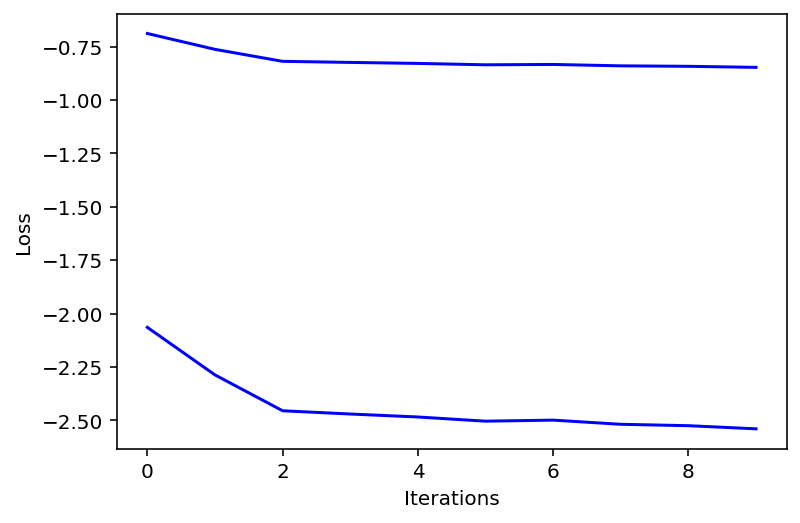

In [ ]:
# plot evolution for training and validation models
MLPdrop_extended = MLPdrop_extended(dimx=28*28,hidden1=256, hidden2=128, hidden3=64, nlabels=10,epochs=10,lr=1e-3)
MLPdrop_extended.trainloop(trainloader,validloader)

plt.plot(MLPdrop_extended.loss_during_training,'-b',label='BCE Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.plot(MLPdrop_extended.valid_loss_during_training,'-b',label='BCE Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [ ]:
train_accuracy = MLPdrop_extended.eval_performance(trainloader)
valid_accuracy = MLPdrop_extended.eval_performance(validloader)
test_accuracy = MLPdrop_extended.eval_performance(testloader)
print("Training performance accuracy for this model is", float(train_accuracy))
print("Validation performance accuracy is", float(train_accuracy))
print("Testing performance accuracy is", float(test_accuracy))


Training performance accuracy for this model is 0.8526500463485718
Validation performance accuracy is 0.8526500463485718
Testing performance accuracy is 0.8341958522796631


LET'S REPEAT NOW FOR DROPOUT PROBABILIIES p=0.1 AND p=0.3 AND SEE WHICH PROVIDES THE BEST VALIDATION PERFORMANCE. Train for 10 epochs again.

In [ ]:
class MLPdrop_1(nn.Module):

    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels):
        super().init()
        self.L1 = nn.Linear(dimx,hidden1)
        self.L2 = nn.Linear(hidden1,hidden2)
        self.L3 = nn.Linear(hidden2,hidden3)
        self.L4 = nn.Linear(hidden3,nlabels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1) # DROPOUT PROBABILITY 0.1
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
      # pass input tensor again through each operation above
      x = self.L1(x)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.L2(x)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.L3(x)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.L4(x)
      x = self.softmax(x)
      return x

In [ ]:
class MLPdrop_1_extended(MLP):

    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs=30,lr=0.001):

        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels)

        self.lr = lr

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.epochs = epochs

        self.criterion = nn.NLLLoss()

        self.loss_during_training = []
        self.valid_loss_during_training = []


    def trainloop(self,trainloader,validloader):
            for e in range(int(self.epochs)):
                running_loss = 0.
                for images, labels in trainloader:
                    self.optim.zero_grad()

                    # forward pass
                    out = self.forward(images.view(images.shape[0], -1))
                    loss = self.criterion(out,labels)
                    running_loss += loss.item()

                    # backwardpass
                    loss.backward() # do backpropagation
                    self.optim.step()

                self.loss_during_training.append(running_loss/len(trainloader))
                self.valid_loss_during_training.append(running_loss/len(validloader))

                if(e % 1 == 0):
                    print("Training loss after %d epochs: %f"
                          %(e,self.loss_during_training[-1]))

    def eval_performance(self,loader):
        loss = 0
        accuracy = 0

        # Turn off gradients for validation
        with torch.no_grad():

            # set model to eval mode (turn off dropout mode)
            self.eval()

            #validation pass
            for images,labels in loader:
                logprobs = self.forward(images.view(images.shape[0], -1))

                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        # set model back to train mode (turn dropout mode back on)
        self.train()

        return accuracy/len(loader)


Training loss after 0 epochs: -0.665202
Training loss after 1 epochs: -0.709505
Training loss after 2 epochs: -0.712515
Training loss after 3 epochs: -0.713740
Training loss after 4 epochs: -0.727236
Training loss after 5 epochs: -0.738436
Training loss after 6 epochs: -0.743407
Training loss after 7 epochs: -0.750551
Training loss after 8 epochs: -0.751758
Training loss after 9 epochs: -0.755890


Text(0, 0.5, 'Loss')

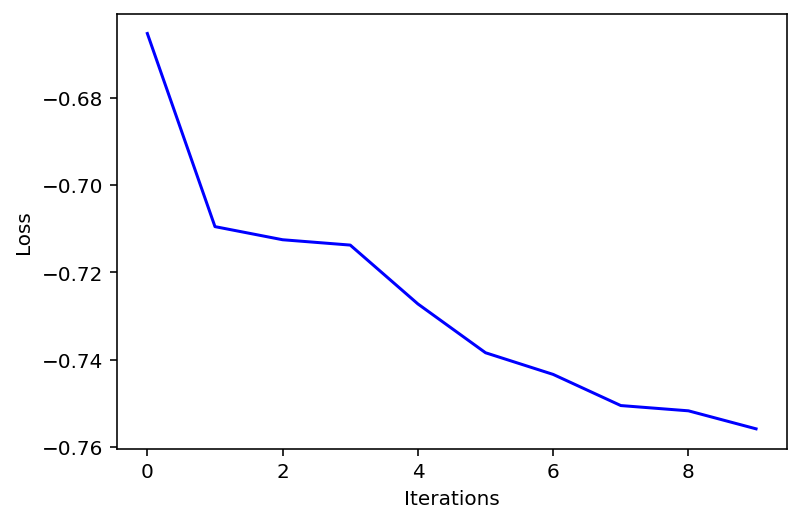

In [ ]:
# plot evolution for training and validation models
MLPdrop_first = MLPdrop_1_extended(dimx=28*28,hidden1=256, hidden2=128, hidden3=64, nlabels=10,epochs=10,lr=1e-3)
MLPdrop_first.trainloop(trainloader,validloader)

plt.plot(MLPdrop_first.loss_during_training,'-b',label='BCE Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [ ]:
# compute train, validation, and test performance
# evaluate train, validation, and test performance

train_accuracy = MLPdrop_first.eval_performance(trainloader)
valid_accuracy = MLPdrop_first.eval_performance(validloader)
test_accuracy = MLPdrop_first.eval_performance(testloader)
print("Training performance accuracy for this model is", float(train_accuracy))
print("Validation performance accuracy is", float(train_accuracy))
print("Testing performance accuracy is", float(test_accuracy))

Training performance accuracy for this model is 0.7559259533882141
Validation performance accuracy is 0.7559259533882141
Testing performance accuracy is 0.7434315085411072


Now let's try with a dropout probability of 0.3 and see which one has the best performance

In [ ]:
class MLPdrop_2(nn.Module):

    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels):
        super().init()
        self.L1 = nn.Linear(dimx,hidden1)
        self.L2 = nn.Linear(hidden1,hidden2)
        self.L3 = nn.Linear(hidden2,hidden3)
        self.L4 = nn.Linear(hidden3,nlabels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3) # DROPOUT PROBABILITY 0.3
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
      x = self.L1(x)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.L2(x)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.L3(x)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.L4(x)
      x = self.softmax(x)
      return x

In [ ]:
class MLPdrop_2_extended(MLP):
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs=30,lr=0.001):

        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels)

        self.lr = lr #Learning Rate

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.epochs = epochs

        self.criterion = nn.NLLLoss()

        self.loss_during_training = []
        self.valid_loss_during_training = []

    def trainloop(self,trainloader,validloader):
            for e in range(int(self.epochs)):
                running_loss = 0.
                for images, labels in trainloader:
                    self.optim.zero_grad()

                    # forward pass
                    out = self.forward(images.view(images.shape[0], -1))
                    loss = self.criterion(out,labels) # compare output with the labels
                    running_loss += loss.item() # update the loss

                    # backwardpass
                    loss.backward() # do backpropagation
                    self.optim.step()

                self.loss_during_training.append(running_loss/len(trainloader))
                self.valid_loss_during_training.append(running_loss/len(validloader))
                if(e % 1 == 0):
                    print("Training loss after %d epochs: %f"
                          %(e,self.loss_during_training[-1]))

    def eval_performance(self,loader):
        loss = 0
        accuracy = 0

        # Turn off gradients for validation
        with torch.no_grad():

            # set model to eval mode
            self.eval()

            #validation pass
            for images,labels in loader:
                logprobs = self.forward(images.view(images.shape[0], -1))

                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        # set model back to train mode
        self.train()

        return accuracy/len(loader)

Training loss after 0 epochs: -0.696890
Training loss after 1 epochs: -0.792698
Training loss after 2 epochs: -0.815323
Training loss after 3 epochs: -0.825103
Training loss after 4 epochs: -0.834248
Training loss after 5 epochs: -0.838383
Training loss after 6 epochs: -0.834520
Training loss after 7 epochs: -0.835742
Training loss after 8 epochs: -0.839225
Training loss after 9 epochs: -0.834637


Text(0, 0.5, 'Loss')

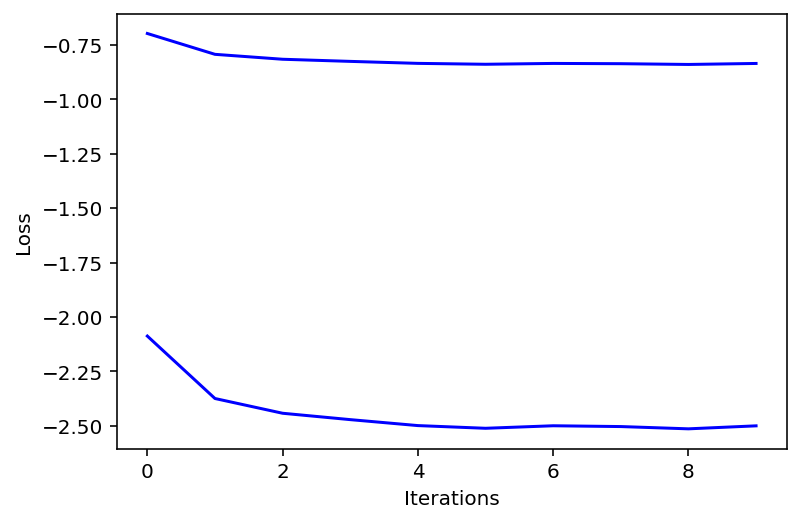

In [ ]:
# plot evolution for training and validation models
MLPdrop_second = MLPdrop_2_extended(dimx=28*28,hidden1=256, hidden2=128, hidden3=64, nlabels=10,epochs=10,lr=1e-3)
MLPdrop_second.trainloop(trainloader,validloader)

plt.plot(MLPdrop_second.loss_during_training,'-b',label='BCE Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.plot(MLPdrop_second.valid_loss_during_training,'-b',label='BCE Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [ ]:
# compute train, validation, and test performance
# evaluate train, validation, and test performance
train_accuracy = MLPdrop_second.eval_performance(trainloader)
valid_accuracy = MLPdrop_second.eval_performance(validloader)
test_accuracy = MLPdrop_second.eval_performance(testloader)
print("Training performance accuracy for this model is", float(train_accuracy))
print("Validation performance accuracy is", float(train_accuracy))
print("Testing performance accuracy is", float(test_accuracy))

Training performance accuracy for this model is 0.8151189684867859
Validation performance accuracy is 0.8151189684867859
Testing performance accuracy is 0.8016520738601685


Concluding remarks: For around 10 epochs, it looks like the MLP with dropout probability 0.2, which is what we originally tried, had the best accuracy. Below we can see a review of the performance for the model with changed dropout probabilities.**  
  

**Performance accuracy with model DROPOUT = 0.2:**  

Training performance: 0.8516

Validation performance: 0.8516

Testing performance accuracy is 0.8318

  
**Performance accuracy with model DROPOUT = 0.1:**  
Training performance 0.75592

Validation performance accuracy is 0.7559

Testing performance accuracy is 0.7434

    
**Performance accuracy with model DROPOUT = 0.3:**  
Training performance 0.81511

Validation performance accuracy is 0.8151  


Testing performance accuracy is 0.801652

So, in conclusion, it looks like the dropout probabiliy that best simplifies the network (and prevents overfitting) is 0.2 for this network.